<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preparation</a></span><ul class="toc-item"><li><span><a href="#Add-lag-features" data-toc-modified-id="Add-lag-features-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Add lag features</a></span></li></ul></li><li><span><a href="#LigthGBM" data-toc-modified-id="LigthGBM-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>LigthGBM</a></span></li><li><span><a href="#Random-forest-from-LigthGBM" data-toc-modified-id="Random-forest-from-LigthGBM-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Random forest from LigthGBM</a></span></li><li><span><a href="#DART" data-toc-modified-id="DART-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>DART</a></span></li><li><span><a href="#GOSS" data-toc-modified-id="GOSS-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>GOSS</a></span></li><li><span><a href="#Boruta" data-toc-modified-id="Boruta-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Boruta</a></span></li><li><span><a href="#Predict-for-Kaggle" data-toc-modified-id="Predict-for-Kaggle-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Predict for Kaggle</a></span></li></ul></div>

In [1]:
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import calendar
import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelBinarizer, LabelEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor

%load_ext autoreload
%autoreload 2

from data_preparation import get_shops, get_item_categories, get_items, prepare_full_dataset, get_duplicate_dict, generate_all_ids_dataset, prepare_zero_dataset, enrich_dataset
from time_series_feats import get_avg_metric, get_lag_metric, calculate_and_add_lag

## Data preparation

In [2]:
train_sales = pd.read_csv('sales_train.csv.zip')
shop_id_map = {0: 57, 1: 58, 10: 11}
train_sales['shop_id'] = train_sales['shop_id'].apply(lambda x: shop_id_map[x] if x in shop_id_map else x)
train_sales['item_cnt_day'] = train_sales['item_cnt_day'].apply(lambda x: x if x > 0 else 0)

In [3]:
item_categories = get_item_categories()
items = get_items(item_categories)

In [4]:
shops = get_shops()

In [5]:
train_sales.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,0.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
items.shape

(22170, 7)

In [6]:
test_df = pd.read_csv('test.csv.zip')

In [7]:
test_df['shop_id'] = test_df['shop_id'].apply(lambda x: shop_id_map[x] if x in shop_id_map else x)

In [8]:
test_df['year'] = 2015
test_df['month'] = 11
test_df['date_block_num'] = 34
test_df['item_price'] = float('nan')
test_df['item_cnt_month'] = 0

In [9]:
dup_item_dict = get_duplicate_dict(items, test_df)
train_sales['item_id'] = train_sales['item_id'].apply(lambda x: dup_item_dict[x] if x in dup_item_dict else x)

In [10]:
item_ids = items[~items.item_id.isin(dup_item_dict.keys())]['item_id'].unique()
shop_ids = shops[~shops.shop_id.isin([0, 1, 10])]['shop_id'].unique()

In [11]:
train_sales['date'] = train_sales['date'].apply(lambda x: datetime.datetime.strptime(x, '%d.%m.%Y'))
train_sales['month'] = train_sales['date'].apply(lambda x: x.month)
train_sales['year'] = train_sales['date'].apply(lambda x: x.year)

In [12]:
train_sales = train_sales[train_sales.item_price<100000]
train_sales = train_sales[train_sales.item_cnt_day<1001]

In [13]:
median = train_sales[(train_sales.shop_id==32)&(train_sales.item_id==2973)&(train_sales.date_block_num==4)&(train_sales.item_price>0)].item_price.median()
train_sales.loc[train_sales.item_price<0, 'item_price'] = median

In [14]:
baseline_train = train_sales[train_sales.item_price > 0].groupby( ['date_block_num', 'shop_id',  'item_id', 'month', 'year']).agg(
    {'item_cnt_day': 'sum', 'item_price':'mean'}).reset_index()
baseline_train = baseline_train.rename(columns={'item_cnt_day':'item_cnt_month'})

In [15]:
baseline_train

,date_block_num,shop_id,item_id,month,year,item_cnt_month,item_price
0,0,2,27,1,2013,1.0,2499.0
1,0,2,33,1,2013,1.0,499.0
2,0,2,317,1,2013,1.0,299.0
3,0,2,438,1,2013,1.0,299.0
4,0,2,471,1,2013,2.0,399.0
...,...,...,...,...,...,...,...
1608805,33,59,22087,10,2015,6.0,119.0
1608806,33,59,22088,10,2015,2.0,119.0
1608807,33,59,22091,10,2015,1.0,179.0
1608808,33,59,22100,10,2015,1.0,629.0


In [16]:
test_df.head(10)

,ID,shop_id,item_id,year,month,date_block_num,item_price,item_cnt_month
0,0,5,5037,2015,11,34,NaN,0
1,1,5,5320,2015,11,34,NaN,0
2,2,5,5233,2015,11,34,NaN,0
3,3,5,5232,2015,11,34,NaN,0
4,4,5,5268,2015,11,34,NaN,0
5,5,5,5039,2015,11,34,NaN,0
6,6,5,5041,2015,11,34,NaN,0
7,7,5,5046,2015,11,34,NaN,0
8,8,5,5319,2015,11,34,NaN,0
9,9,5,5003,2015,11,34,NaN,0


In [17]:
%%time
all_ids_dataset = generate_all_ids_dataset(item_ids, shop_ids)

Wall time: 57.5 s


In [18]:
num_to_month = baseline_train[['date_block_num', 'month', 'year']].drop_duplicates()
all_ids_dataset = all_ids_dataset.merge(num_to_month, how = 'left', on=['date_block_num'])

In [19]:
%%time
train_with_zeroes = all_ids_dataset.merge(baseline_train, 
                 how='left', on=[ 'shop_id', 'item_id', 'date_block_num', 'month', 'year' ])

Wall time: 31.4 s


In [21]:
del all_ids_dataset
del baseline_train

In [20]:
train_with_zeroes.head(10)

,date_block_num,shop_id,item_id,month,year,item_cnt_month,item_price
0,0,2,0,1,2013,NaN,NaN
1,0,2,1,1,2013,NaN,NaN
2,0,2,2,1,2013,NaN,NaN
3,0,2,3,1,2013,NaN,NaN
4,0,2,4,1,2013,NaN,NaN
5,0,2,5,1,2013,NaN,NaN
6,0,2,6,1,2013,NaN,NaN
7,0,2,7,1,2013,NaN,NaN
8,0,2,8,1,2013,NaN,NaN
9,0,2,9,1,2013,NaN,NaN


In [24]:
train_with_zeroes.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42851118 entries, 0 to 42851117
Data columns (total 7 columns):
 #   Column          Non-Null Count     Dtype  
---  ------          --------------     -----  
 0   date_block_num  42851118 non-null  int8   
 1   shop_id         42851118 non-null  int8   
 2   item_id         42851118 non-null  int16  
 3   month           42851118 non-null  int64  
 4   year            42851118 non-null  int64  
 5   item_cnt_month  1608810 non-null   float64
 6   item_price      42851118 non-null  float64
dtypes: float64(2), int16(1), int64(2), int8(2)
memory usage: 1.8 GB


In [23]:
train_with_zeroes.sort_values(by='date_block_num', inplace=True)
train_with_zeroes['item_price'] = train_with_zeroes.groupby(['item_id', 'shop_id'])['item_price'].ffill().bfill()
train_with_zeroes['item_price'] = train_with_zeroes.groupby(['item_id'])['item_price'].ffill().bfill()

In [25]:
train_with_zeroes.fillna(0, inplace=True)

In [26]:
train_with_zeroes['year'] = train_with_zeroes['year'].astype(np.int16)
train_with_zeroes['month'] = train_with_zeroes['month'].astype(np.int8)
train_with_zeroes['date_block_num'] = train_with_zeroes['date_block_num'].astype(np.int8)
train_with_zeroes['item_cnt_month'] = train_with_zeroes['item_cnt_month'].astype(np.int16)

In [27]:
test_df['year'] = test_df['year'].astype(np.int16)
test_df['month'] = test_df['month'].astype(np.int8)
test_df['date_block_num'] = test_df['date_block_num'].astype(np.int8)
test_df['item_cnt_month'] = test_df['item_cnt_month'].astype(np.int16)

In [28]:
test_df.head(10)

,ID,shop_id,item_id,year,month,date_block_num,item_price,item_cnt_month
0,0,5,5037,2015,11,34,NaN,0
1,1,5,5320,2015,11,34,NaN,0
2,2,5,5233,2015,11,34,NaN,0
3,3,5,5232,2015,11,34,NaN,0
4,4,5,5268,2015,11,34,NaN,0
5,5,5,5039,2015,11,34,NaN,0
6,6,5,5041,2015,11,34,NaN,0
7,7,5,5046,2015,11,34,NaN,0
8,8,5,5319,2015,11,34,NaN,0
9,9,5,5003,2015,11,34,NaN,0


In [29]:
train_with_zeroes.head(10)

,date_block_num,shop_id,item_id,month,year,item_cnt_month,item_price
0,0,2,0,1,2013,0,499.0
840221,0,41,3,1,2013,0,499.0
840220,0,41,2,1,2013,0,499.0
840219,0,41,1,1,2013,0,499.0
840218,0,41,0,1,2013,0,499.0
840217,0,40,22169,1,2013,0,499.0
840216,0,40,22168,1,2013,0,499.0
840215,0,40,22167,1,2013,0,499.0
840214,0,40,22166,1,2013,0,499.0
840213,0,40,22165,1,2013,0,499.0


In [32]:
test_lag_set = test_df[['item_id', 'shop_id', 'ID']].merge(train_with_zeroes, on = ['shop_id', 'item_id'])

In [40]:
test_df_full.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7495572 entries, 0 to 214199
Data columns (total 8 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   item_id         7495572 non-null  int16  
 1   shop_id         7495572 non-null  int8   
 2   ID              7495572 non-null  int32  
 3   date_block_num  7495572 non-null  int8   
 4   month           7495572 non-null  int8   
 5   year            7495572 non-null  int16  
 6   item_cnt_month  7495572 non-null  int16  
 7   item_price      7495572 non-null  float64
dtypes: float64(1), int16(3), int32(1), int8(3)
memory usage: 207.3 MB


In [34]:
test_df_full = pd.concat([test_lag_set, test_df])
test_df_full.sort_values(by=['date_block_num'], inplace=True)

In [36]:
del test_lag_set
del test_df

In [37]:
test_df_full['shop_id'] = test_df_full['shop_id'].astype(np.int8)
test_df_full['item_id'] = test_df_full['item_id'].astype(np.int16)
test_df_full['ID'] = test_df_full['ID'].astype(np.int32)

In [39]:
test_df_full['item_price'] = test_df_full.groupby(['item_id', 'shop_id'])['item_price'].ffill().bfill()
test_df_full['item_price'] = test_df_full.groupby(['item_id'])['item_price'].ffill().bfill()

In [41]:
%%time
full_train = enrich_dataset(train_with_zeroes, items, shops)

Wall time: 58.8 s


In [42]:
full_train.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42851118 entries, 0 to 42851117
Data columns (total 12 columns):
 #   Column            Non-Null Count     Dtype  
---  ------            --------------     -----  
 0   date_block_num    42851118 non-null  int8   
 1   shop_id           42851118 non-null  int8   
 2   item_id           42851118 non-null  int16  
 3   month             42851118 non-null  int8   
 4   year              42851118 non-null  int16  
 5   item_cnt_month    42851118 non-null  int16  
 6   item_price        42851118 non-null  float64
 7   shop_type         42851118 non-null  object 
 8   city              42851118 non-null  object 
 9   item_category_id  42851118 non-null  int64  
 10  category          42851118 non-null  object 
 11  sub_category      42851118 non-null  object 
dtypes: float64(1), int16(3), int64(1), int8(3), object(4)
memory usage: 2.6+ GB


In [43]:
%%time
full_test = enrich_dataset(test_df_full, items, shops)

Wall time: 10.5 s


In [44]:
full_test.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7495572 entries, 0 to 7495571
Data columns (total 13 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   item_id           7495572 non-null  int16  
 1   shop_id           7495572 non-null  int8   
 2   ID                7495572 non-null  int32  
 3   date_block_num    7495572 non-null  int8   
 4   month             7495572 non-null  int8   
 5   year              7495572 non-null  int16  
 6   item_cnt_month    7495572 non-null  int16  
 7   item_price        7495572 non-null  float64
 8   shop_type         7495572 non-null  object 
 9   city              7495572 non-null  object 
 10  item_category_id  7495572 non-null  int64  
 11  category          7495572 non-null  object 
 12  sub_category      7495572 non-null  object 
dtypes: float64(1), int16(3), int32(1), int64(1), int8(3), object(4)
memory usage: 493.2+ MB


In [45]:
full_train['item_category_id'] = full_train['item_category_id'].astype(np.int8)
full_test['item_category_id'] = full_test['item_category_id'].astype(np.int8)

In [46]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [47]:
%%time
full_train = lag_feature(full_train, [1,2,3,6,12], 'item_cnt_month')

Wall time: 3min 37s


In [49]:
%%time
full_test = lag_feature(full_test, [1,2,3,6,12], 'item_cnt_month')

Wall time: 48 s


In [48]:
def convert_lag(df):
    df['item_cnt_month_lag_1'] = df['item_cnt_month_lag_1'].astype(np.float16)
    df['item_cnt_month_lag_2'] = df['item_cnt_month_lag_2'].astype(np.float16)
    df['item_cnt_month_lag_3'] = df['item_cnt_month_lag_3'].astype(np.float16)
    df['item_cnt_month_lag_6'] = df['item_cnt_month_lag_6'].astype(np.float16)
    df['item_cnt_month_lag_12'] = df['item_cnt_month_lag_12'].astype(np.float16)

In [50]:
convert_lag(full_train)
convert_lag(full_test)

In [51]:
real_train = full_train[full_train.date_block_num > 11]

In [52]:
real_test = full_test[full_test.date_block_num == 34]

In [53]:
def enrich_real_train(full_df, real_df, cols, date_block=None):
    group_by_cols, group_cols = calculate_and_add_lag(full_df, cols, date_block)
    real_df = pd.merge(real_df, group_by_cols, on=group_cols, how='left')
    return real_df

### Add lag features

In [54]:
%%time
real_train = enrich_real_train(full_train, real_train, ['date_block_num', 'item_id'])

Wall time: 36.6 s


In [55]:
def convert_avg_lag_values(df, columns):
    grouping = '_'.join(columns)
    column_name = f'{grouping}_avg_item_cnt_lag_'
    for lag in [1, 2, 3, 6, 9, 12]:
        col = f"{column_name}{lag}"
        df[col] = df[col].astype(np.float16)

In [56]:
convert_avg_lag_values(real_train, ['item_id'])

In [63]:
real_train.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27727194 entries, 0 to 27727193
Data columns (total 29 columns):
 #   Column                       Non-Null Count     Dtype  
---  ------                       --------------     -----  
 0   date_block_num               27727194 non-null  int8   
 1   shop_id                      27727194 non-null  int8   
 2   item_id                      27727194 non-null  int16  
 3   month                        27727194 non-null  int8   
 4   year                         27727194 non-null  int16  
 5   item_cnt_month               27727194 non-null  int16  
 6   item_price                   27727194 non-null  float64
 7   shop_type                    27727194 non-null  object 
 8   city                         27727194 non-null  object 
 9   item_category_id             27727194 non-null  int8   
 10  category                     27727194 non-null  object 
 11  sub_category                 27727194 non-null  object 
 12  item_cnt_month_lag_1      

In [58]:
%%time
real_test = enrich_real_train(full_test, real_test, ['date_block_num', 'item_id'])

Wall time: 3.98 s


In [59]:
convert_avg_lag_values(real_test, ['item_id'])

In [60]:
real_test.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 24 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   item_id                      214200 non-null  int16  
 1   shop_id                      214200 non-null  int8   
 2   ID                           214200 non-null  int32  
 3   date_block_num               214200 non-null  int8   
 4   month                        214200 non-null  int8   
 5   year                         214200 non-null  int16  
 6   item_cnt_month               214200 non-null  int16  
 7   item_price                   214200 non-null  float64
 8   shop_type                    214200 non-null  object 
 9   city                         214200 non-null  object 
 10  item_category_id             214200 non-null  int8   
 11  category                     214200 non-null  object 
 12  sub_category                 214200 non-null  object 
 13 

In [61]:
%time
real_train = enrich_real_train(full_train, real_train, ['date_block_num', 'shop_id'])

Wall time: 0 ns


In [64]:
convert_avg_lag_values(real_train, ['shop_id'])

In [65]:
%time
real_test = enrich_real_train(full_test, real_test, ['date_block_num', 'shop_id'])

Wall time: 0 ns


In [66]:
convert_avg_lag_values(real_test, ['shop_id'])

In [67]:
%%time
real_train = enrich_real_train(full_train, real_train, ['date_block_num', 'shop_id', 'item_id'])

Wall time: 14min 23s


In [68]:
convert_avg_lag_values(real_train, ['shop_id', 'item_id'])

In [69]:
%%time
real_test = enrich_real_train(full_test, real_test, ['date_block_num', 'shop_id', 'item_id'])

Wall time: 2min 34s


In [70]:
convert_avg_lag_values(real_test, ['shop_id', 'item_id'])

In [71]:
%%time
real_train = enrich_real_train(full_train, real_train, ['date_block_num',  'item_category_id'])

Wall time: 22 s


In [72]:
convert_avg_lag_values(real_train, ['item_category_id'])

In [73]:
%%time
real_test = enrich_real_train(full_test, real_test, ['date_block_num',  'item_category_id'])

Wall time: 1.65 s


In [74]:
convert_avg_lag_values(real_test, ['item_category_id'])

In [75]:
%%time
real_train = enrich_real_train(full_train, real_train, ['date_block_num', 'category'])

Wall time: 29.7 s


In [76]:
convert_avg_lag_values(real_train, ['category'])

In [77]:
%%time
real_test = enrich_real_train(full_test, real_test, ['date_block_num', 'category'])

Wall time: 3.98 s


In [78]:
convert_avg_lag_values(real_test, ['category'])

In [79]:
%%time
real_train = enrich_real_train(full_train, real_train, ['date_block_num', 'sub_category'])

Wall time: 38.6 s


In [80]:
convert_avg_lag_values(real_train, ['sub_category'])

In [81]:
%%time
real_test = enrich_real_train(full_test, real_test, ['date_block_num', 'sub_category'])

Wall time: 3.25 s


In [82]:
convert_avg_lag_values(real_test, ['sub_category'])

In [83]:
%%time
real_train = enrich_real_train(full_train, real_train, ['date_block_num', 'shop_id', 'category'])

Wall time: 47.7 s


In [84]:
convert_avg_lag_values(real_train, ['shop_id', 'category'])

In [85]:
%%time
real_test = enrich_real_train(full_test, real_test, ['date_block_num', 'shop_id', 'category'])

Wall time: 4.18 s


In [86]:
convert_avg_lag_values(real_test, ['shop_id', 'category'])

In [87]:
%%time
real_train = enrich_real_train(full_train, real_train, ['date_block_num', 'shop_id', 'sub_category'])

Wall time: 54.7 s


In [88]:
convert_avg_lag_values(real_train, ['shop_id', 'sub_category'])

In [89]:
%%time
real_test = enrich_real_train(full_test, real_test, ['date_block_num', 'shop_id', 'sub_category'])

Wall time: 5.07 s


In [90]:
convert_avg_lag_values(real_test, ['shop_id', 'sub_category'])

In [91]:
%%time
real_train = enrich_real_train(full_train, real_train, ['date_block_num', 'shop_id', 'item_category_id'])

Wall time: 44.6 s


In [92]:
convert_avg_lag_values(real_train, ['shop_id', 'item_category_id'])

In [93]:
%%time
real_test = enrich_real_train(full_test, real_test, ['date_block_num', 'shop_id', 'item_category_id'])

Wall time: 4.19 s


In [94]:
convert_avg_lag_values(real_test, ['shop_id', 'item_category_id'])

In [95]:
%%time
real_train = enrich_real_train(full_train, real_train, ['date_block_num',  'city'])

Wall time: 48.4 s


In [97]:
convert_avg_lag_values(real_train, [ 'city'])

In [98]:
%%time
real_test = enrich_real_train(full_test, real_test, ['date_block_num', 'city'])

Wall time: 4.03 s


In [99]:
convert_avg_lag_values(real_test, ['city'])

In [100]:
real_train.drop(columns=['category', 'sub_category', 'city', 'shop_type', 'item_category_id'], inplace=True)

In [101]:
real_test.drop(columns=['category', 'sub_category', 'city', 'shop_type', 'item_category_id'], inplace=True)

In [102]:
del full_train
del full_test

In [103]:
real_train.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27727194 entries, 0 to 27727193
Data columns (total 72 columns):
 #   Column                                        Non-Null Count     Dtype  
---  ------                                        --------------     -----  
 0   date_block_num                                27727194 non-null  int8   
 1   shop_id                                       27727194 non-null  int8   
 2   item_id                                       27727194 non-null  int16  
 3   month                                         27727194 non-null  int8   
 4   year                                          27727194 non-null  int16  
 5   item_cnt_month                                27727194 non-null  int16  
 6   item_price                                    27727194 non-null  float64
 7   item_cnt_month_lag_1                          27727194 non-null  float16
 8   item_cnt_month_lag_2                          27727194 non-null  float16
 9   item_cnt_month_lag_3  

In [104]:
real_test.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 73 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   item_id                                       214200 non-null  int16  
 1   shop_id                                       214200 non-null  int8   
 2   ID                                            214200 non-null  int32  
 3   date_block_num                                214200 non-null  int8   
 4   month                                         214200 non-null  int8   
 5   year                                          214200 non-null  int16  
 6   item_cnt_month                                214200 non-null  int16  
 7   item_price                                    214200 non-null  float64
 8   item_cnt_month_lag_1                          214158 non-null  float16
 9   item_cnt_month_lag_2                          21

In [100]:
#real_train['before_ny'] = real_train['month'].apply(lambda x: int(x == 12))

## LigthGBM

In [105]:
y = real_train['item_cnt_month']
real_train.drop(columns= ['item_cnt_month'], inplace=True)
X = real_train

In [56]:
def cross_val_ts(df_x, df_y, date_block_start, model):
    scores = []
    for i in range(date_block_start, 34):
        start = time.time()
        
        model.fit(df_x[df_x.date_block_num < i], df_y[df_x.date_block_num < i])
        y_pred = model.predict(df_x[df_x.date_block_num == i])
        score = mean_squared_error(df_y[df_x.date_block_num == i], y_pred, squared=False)
        scores.append(score)
        end = time.time()
        print(f"{i} date_block_num: score {score}  time: {end - start}")
        
    return scores

In [106]:
lgbm = LGBMRegressor()

In [ ]:
%%time



cv_score = cross_val_ts(X, y, 19, lgbm)


19 date_block_num: score 0.6012681023630141  time: 118.454185962677
20 date_block_num: score 1.4531467823003883  time: 161.16838431358337
21 date_block_num: score 1.5521796788955946  time: 174.46910667419434
22 date_block_num: score 1.5588111371914457  time: 141.95349979400635
23 date_block_num: score 1.4493175279412236  time: 145.59723162651062
24 date_block_num: score 1.9062718814713022  time: 158.18822360038757
25 date_block_num: score 1.216990769635748  time: 172.7915334701538
26 date_block_num: score 0.9657911417602675  time: 195.5996551513672
27 date_block_num: score 1.9551246204902415  time: 213.81247973442078
28 date_block_num: score 1.2486635633260885  time: 239.67383098602295
29 date_block_num: score 0.6238702871245668  time: 333.9442615509033
30 date_block_num: score 0.4732667308770808  time: 387.345995426178


In [65]:
block_month_mapping = {x['date_block_num']: f"{x['month']}-{x['year']}"  for x in num_to_month.to_dict('records')}

In [70]:
months = [block_month_mapping[x] for x in range(19, 34)]

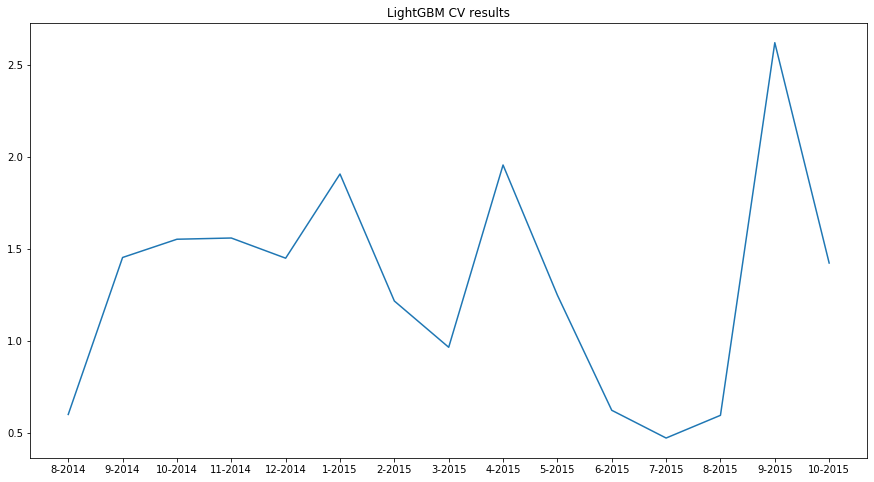

In [110]:
plt.figure(figsize=(15,8))
plt.plot(months, cv_score)
plt.title('LightGBM CV results')
plt.savefig('lgbm_cv.png')
plt.show()

In [107]:
lgbm.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [74]:
np.mean(cv_score)

1.3095456526244884

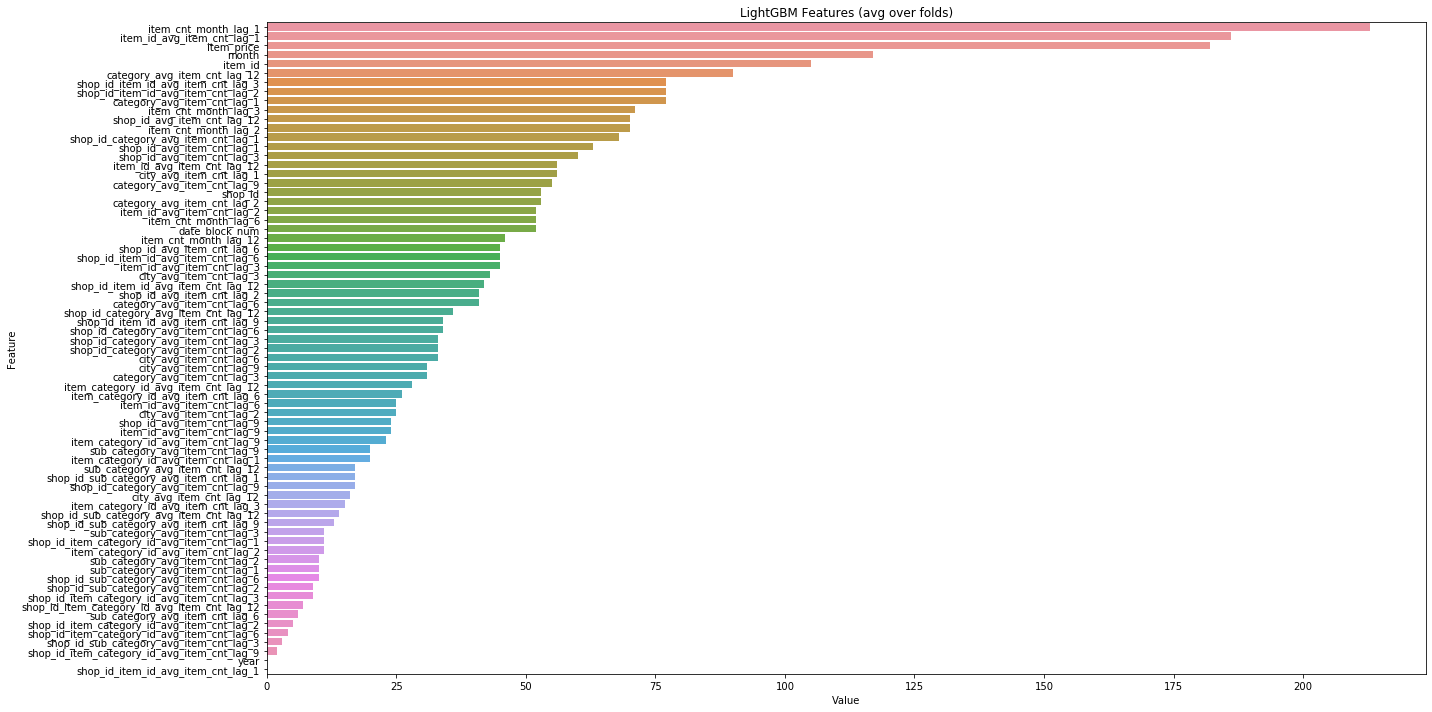

In [85]:
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances-lightgbm.png')
plt.show()

## Random forest from LigthGBM

In [122]:
rf = LGBMRegressor(boosting_type="rf",
                  num_leaves=165,
                         colsample_bytree=.5,
                         n_estimators=400,
                         min_child_weight=5,
                         min_child_samples=10,
                         subsample=.632, # Standard RF bagging fraction
                         subsample_freq=1,
                         min_split_gain=0)

In [81]:
%%time



cv_score_rf = cross_val_ts(X, y, 19, rf)

19 date_block_num: score 0.634571408498895  time: 528.4017815589905
20 date_block_num: score 1.450466178345893  time: 596.4778120517731
21 date_block_num: score 1.5138607483543216  time: 734.2443838119507
22 date_block_num: score 1.524072875760778  time: 801.1323359012604
23 date_block_num: score 1.541850290929419  time: 875.0966079235077
24 date_block_num: score 1.5752675600804646  time: 960.8822152614594
25 date_block_num: score 1.2700719704861068  time: 972.0055384635925
26 date_block_num: score 0.9551818788603137  time: 985.9307310581207
27 date_block_num: score 1.8999906717488533  time: 31916.681037902832
28 date_block_num: score 1.2602446723760188  time: 1341.2026681900024
29 date_block_num: score 0.5841130924150757  time: 1427.2276158332825
30 date_block_num: score 0.4268005730736011  time: 1600.6581585407257
31 date_block_num: score 0.5669429349090397  time: 1832.8468556404114
32 date_block_num: score 2.6185731242821095  time: 1749.4517760276794
33 date_block_num: score 1.05986

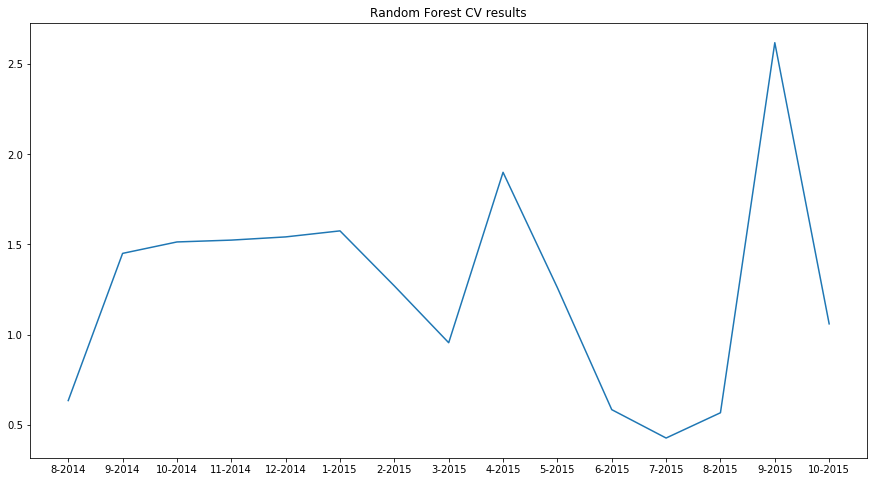

In [111]:
plt.figure(figsize=(15,8))
plt.plot(months, cv_score_rf)
plt.title("Random Forest CV results")
plt.savefig('rf_cv.png')
plt.show()

In [83]:
np.mean(cv_score_rf)

1.2587916468192075

In [ ]:
rf.fit(X, y)

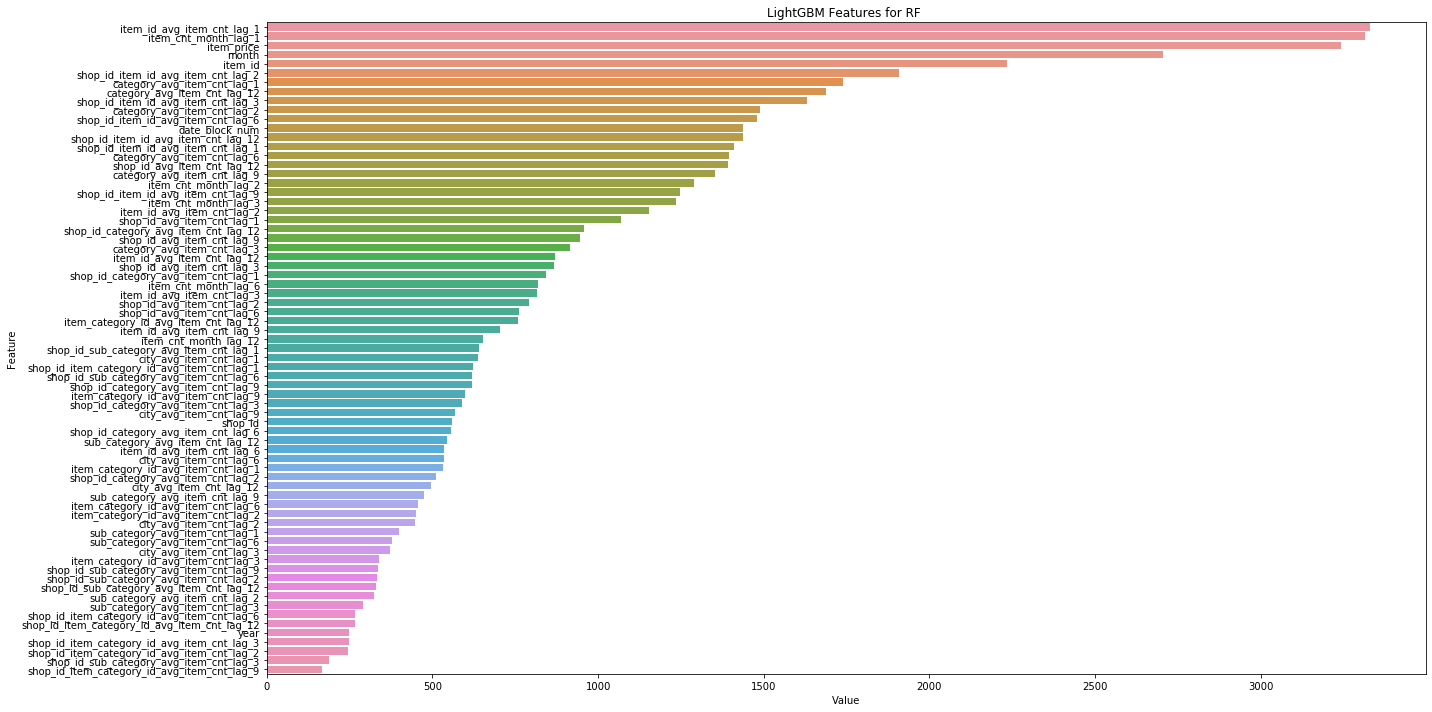

In [87]:
feature_imp_rf = pd.DataFrame(sorted(zip(rf.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp_rf.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features for RF ')
plt.tight_layout()
plt.savefig('lgbm_importances-rf.png')
plt.show()

## DART

In [ ]:
dart = lgb.LGBMClassifier(boosting_type="dart",
                         n_jobs=3)

In [ ]:
%%time



cv_score_dart = cross_val_ts(X, y, 19, dart)

## GOSS

In [ ]:
goss = lgb.LGBMClassifier(boosting_type="goss",
                         n_jobs=3)

In [ ]:
%%time



cv_score_goss = cross_val_ts(X, y, 19, goss)

## Boruta

In [108]:
from boruta import BorutaPy

In [109]:
trans = BorutaPy(lgbm, random_state=42, verbose=2)
sel = trans.fit_transform(X.values, y.values)

MemoryError: Unable to allocate 14.7 GiB for an array with shape (71, 27727194) and data type float64

## Predict for Kaggle

In [108]:
real_test.head()

,item_id,shop_id,ID,date_block_num,month,year,item_cnt_month,item_price,item_cnt_month_lag_1,item_cnt_month_lag_2,...,shop_id_item_category_id_avg_item_cnt_lag_3,shop_id_item_category_id_avg_item_cnt_lag_6,shop_id_item_category_id_avg_item_cnt_lag_9,shop_id_item_category_id_avg_item_cnt_lag_12,city_avg_item_cnt_lag_1,city_avg_item_cnt_lag_2,city_avg_item_cnt_lag_3,city_avg_item_cnt_lag_6,city_avg_item_cnt_lag_9,city_avg_item_cnt_lag_12
0,5037,5,0,34,11,2015,0,749.500000,0.0,1.0,...,0.750000,0.604980,0.518066,0.545410,0.202759,0.204102,0.215820,0.193726,0.186157,0.200317
1,5037,57,137700,34,11,2015,0,1499.000000,1.0,0.0,...,0.530762,0.498779,0.536621,0.681152,0.359131,0.347412,0.365723,0.344482,0.359131,0.410156
2,5037,45,209100,34,11,2015,0,1499.000000,2.0,1.0,...,0.264404,0.221436,0.211914,0.271973,0.141113,0.136841,0.135620,0.125854,0.128296,0.141602
3,5037,3,15300,34,11,2015,0,1365.666667,0.0,0.0,...,0.409424,0.403564,0.382568,0.442383,0.119263,0.123657,0.123535,0.119141,0.120056,0.132324
4,5037,48,132600,34,11,2015,0,749.000000,0.0,1.0,...,0.747559,0.640625,0.571289,0.616699,0.216309,0.213989,0.224731,0.206909,0.199097,0.218750


In [109]:
real_test.drop(columns=['item_cnt_month'], inplace=True)

In [117]:
id_mapping = real_test[['ID', 'shop_id', 'item_id']].drop_duplicates()

In [111]:
y_pred = lgbm.predict(real_test.drop(columns=['ID']))

In [112]:
result_df = real_test[['shop_id', 'item_id']]

In [113]:
result_df['item_cnt_month'] = y_pred

In [114]:
result_df.head()

,shop_id,item_id,item_cnt_month
0,5,5037,0.879605
1,57,5037,1.063415
2,45,5037,0.864870
3,3,5037,0.470465
4,48,5037,1.070212


In [118]:
final_result = id_mapping.merge(result_df, on=['shop_id', 'item_id'], how='left')

In [119]:
final_result.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ID              214200 non-null  int32  
 1   shop_id         214200 non-null  int8   
 2   item_id         214200 non-null  int16  
 3   item_cnt_month  214200 non-null  float64
dtypes: float64(1), int16(1), int32(1), int8(1)
memory usage: 4.7 MB


In [120]:
def save_prediction(predicted_df, filename):
    subm = pd.read_csv('sample_submission.csv.zip')[['ID']]
    res = subm.merge(predicted_df, on='ID', how='left')
    res = res.drop(columns=['item_id', 'shop_id'])
    res.to_csv(filename, index=False)
    return res

In [121]:
save_prediction(final_result, 'lgbm_1.csv')

,ID,item_cnt_month
0,0,0.879605
1,1,0.031695
2,2,1.406755
3,3,0.697424
4,4,0.023359
...,...,...
214195,214195,0.139103
214196,214196,0.008796
214197,214197,0.109958
214198,214198,0.023625
